In [1]:
import numpy as np
import ase.io 
import MDAnalysis as mda
from MDAnalysis.analysis.density import DensityAnalysis
from MDAnalysis.analysis.lineardensity import LinearDensity
import ase
from ase import Atoms
from ase.visualize import view
import matplotlib.pyplot as plt
import MDAnalysis.analysis.msd as msd



Load trajectory

In [3]:
data_path = '/home/nco24/michaelides-share/niamhon/conferences-trips/LJC-SummerSchool/Basic_MD/Part-2/data'
traj = 'traj_unwrapped_0.dcd'
top = 'init_nvt.xyz'

Create mda Universe

In [4]:
u = mda.Universe(f'{data_path}/{top}', f'{data_path}/{traj}', format = 'LAMMPS')
atoms = u.select_atoms('all')   
set(atoms.types)
na = u.select_atoms('name Na')
cl = u.select_atoms('name Cl')
c = u.select_atoms('name C')
ox = u.select_atoms('name O')  

/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Density Profiles

In [30]:
u.add_TopologyAttr('charges')

binsize=0.05
D = LinearDensity(na, delta=1.0, binsize=binsize)
D.run(step=1)

# save output
hist = D.results['z']['pos']
bincenters = np.arange(len(hist))*binsize
density_na = np.array([bincenters, hist]).transpose()
# np.savetxt('density_z.dat', density)

D = LinearDensity(cl, delta=1.0, binsize=binsize)
D.run(step=1)

# save output
hist = D.results['z']['pos']
bincenters = np.arange(len(hist))*binsize
density_cl = np.array([bincenters, hist]).transpose()


/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/MDAnalysis/analysis/lineardensity.py:53: DeprecationWarning: `pos` is deprecated and will be removed in version 3.0.0. Please use `mass_density` instead.
  warnings.warn(


In [39]:
D = LinearDensity(c, delta=1.0, binsize=binsize)
D.run(step=1)

# save output
hist = D.results['z']['pos']
bincenters = np.arange(len(hist))*binsize
density_c = np.array([bincenters, hist]).transpose()


/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/MDAnalysis/analysis/lineardensity.py:53: DeprecationWarning: `pos` is deprecated and will be removed in version 3.0.0. Please use `mass_density` instead.
  warnings.warn(


Text(0, 0.5, 'Density $\\AA^{-3}$')

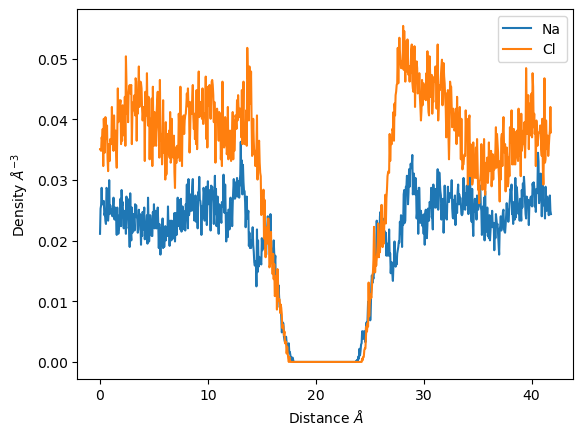

In [41]:
fig, ax = plt.subplots()
ax.plot(density_na[:,0], density_na[:,1], label = 'Na')    
ax.plot(density_cl[:,0], density_cl[:,1], label = 'Cl')
# ax.plot(density_c[:,0], density_c[:,1], label = 'Cl')

ax.legend()
ax.set_xlabel(r'Distance $\AA$')
ax.set_ylabel(r'Density $\AA^{-3}$')

Water orientation

Diffusion

In [8]:
MSD = msd.EinsteinMSD(u, select='name O', msd_type='xyz', fft=True)
MSD.run()


100%|██████████| 500/500 [00:01<00:00, 261.71it/s]


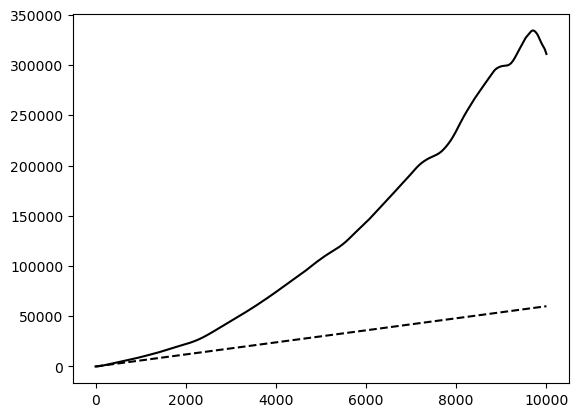

In [12]:
msd =  MSD.results.timeseries
import matplotlib.pyplot as plt
nframes = MSD.n_frames
timestep = 1 # this needs to be the actual time between frames
lagtimes = np.arange(nframes)*timestep # make the lag-time axis
fig = plt.figure()
ax = plt.axes()
# plot the actual MSD
ax.plot(lagtimes, msd, c="black", ls="-", label=r'3D random walk')
exact = lagtimes*6
# plot the exact result
ax.plot(lagtimes, exact, c="black", ls="--", label=r'$y=2 D\tau$')
plt.show()


Conductivity